# Investigating Impact of Odometry Noise On FITAM Performance

In [ ]:
%load_ext autoreload 
%autoreload 2

## Add noise to trajectory

In [2]:
from typing import NamedTuple
class NoiseParams(NamedTuple):
    longitundal_std_m_per_meter: float
    yaw_std_rad_per_meter: float
import numpy as np

def create_random_trajectory(n_points, generator:np.random.Generator = np.random.default_rng(42)):
    traj = []
    start = (5,3)
    traj.append(start)
    for i in range(n_points):
        delta = generator.uniform(0, 1, (2)) - 0.1
        traj.append((traj[i][0] + delta[0], traj[i][1]+delta[1]))
    return traj



def find_r_theta_from_delta(last_state, next_state):
    r = np.sqrt((next_state[0]-last_state[0])**2 + (next_state[1]-last_state[1])**2)
    theta = np.arctan2(next_state[1] - last_state[1], next_state[0] - last_state[0])
    return r, theta
def build_trajectory_from_deltas(deltas: list, initial_state):
    trajectory = [initial_state]
    last_state = initial_state
    for d in deltas:
        last_state = (last_state[0] + d[0] * np.cos(d[1]), last_state[1] + d[0] * np.sin(d[1]))
        trajectory.append(last_state)
    return trajectory

def trajectory_to_deltas(state_sequence: list[tuple[float, float]]):
    deltas = []
    for i in range(1, len(state_sequence)):
        deltas.append(find_r_theta_from_delta(state_sequence[i-1], state_sequence[i]))
    return deltas
    

def add_noise_to_deltas(deltas: list[tuple[float, float]], noise_params: NoiseParams, generator: np.random.Generator):
    deltas = np.asarray(deltas)
    noise = generator.normal(np.zeros((1, 2)), np.asarray([noise_params.longitundal_std_m_per_meter * deltas[:, 0], noise_params.yaw_std_rad_per_meter * deltas[:, 0]]).T)
    accumulated_heading_error = np.cumsum(noise[:, 1])
    noise[:, 1] = accumulated_heading_error
    return (deltas + noise).tolist(), noise[:, 1]

def add_noise_to_trajectory(trajectory: list[tuple[float,float]], noise_params: NoiseParams, generator: np.random.Generator):
    deltas = trajectory_to_deltas(trajectory)
    noise_deltas, acc_heading_err = add_noise_to_deltas(deltas, noise_params, generator)
    noise_traj = build_trajectory_from_deltas(noise_deltas, trajectory[0])
    return noise_traj, acc_heading_err


Deltas [(0.7543575758975005, 0.4659008967875311), (0.9655668626439834, 0.6670497345947717), (0.8756417109546029, 1.5774459586595602), (0.9527801092188284, 0.8038970395520151), (0.35151199384540416, 1.4907316575268845), (0.8699838600308046, 1.254269436406461), (0.9045295011541683, 0.9257086155720479), (0.36622807685599684, 0.3548292701230644), (0.45602249894282887, -0.07942769644437603), (0.9011737655686199, 0.6310201907563944), (0.7055940349118056, 0.3690459638031198), (1.177775939121091, 0.7388061044087119), (0.6849530305983883, 0.13861160693937805), (0.37100176726568374, -0.15205688961110408), (0.5855710297018418, 1.4779509397565478), (1.0808752812230322, 0.9316399648845405), (0.35234293659259347, 0.8750937596463052), (0.3802323260114918, 0.23753450956929084), (0.376894531761838, 1.4913230965433708), (0.5837756173501589, 1.3516524490737352), (0.8065288310890447, 1.139522473440428), (0.6367242598281128, 0.3400455119853327), (1.0163155102315529, 0.7662668988645187), (0.3436732359957312

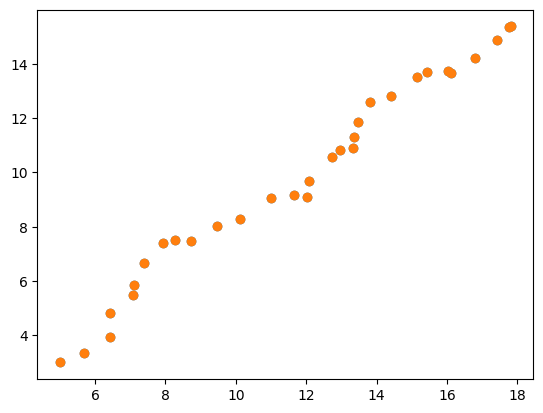

In [4]:
trajectory = create_random_trajectory(30)
# trajectory = [(1,1), (1,2), (2,2), (2,1), (1,1)]
deltas = trajectory_to_deltas(trajectory)
print("Deltas", deltas)
recreated_traj = build_trajectory_from_deltas(deltas, trajectory[0])
print("Recreated trajectory", recreated_traj)

import matplotlib.pyplot as plt
plt.figure()
plt.scatter([x[0] for x in trajectory], [x[1] for x in trajectory])
plt.scatter([x[0] for x in recreated_traj], [x[1] for x in recreated_traj])


(5, 3) (5, 3)


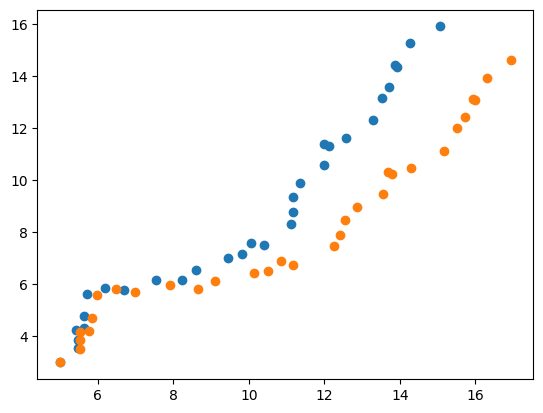

In [6]:
trajectory = create_random_trajectory(30)
noisy_trajectory, _ = add_noise_to_trajectory(trajectory, NoiseParams(0.1, 0.1), np.random.default_rng(42))
print(noisy_trajectory[0], trajectory[0])
plt.figure()
plt.scatter([x[0] for x in trajectory], [x[1] for x in trajectory])
plt.scatter([x[0] for x in noisy_trajectory], [x[1] for x in noisy_trajectory])

## Create noisy inputs for dataset generation

In [7]:
from fitam.mapping.land_cover_complex_map import LandCoverComplexMap
from fitam.mapping.costmap_swath_library import SwathLibrary
from scipy.ndimage import rotate
from fitam.core.common import load_json_config
import pandas as pd 
from fitam import IMAGES_DIR, MAPS_DIR, CONFIGS_DIR

,map_path,img_path,yaw_left,yaw_right,x,y,camera_name
0,training_map/masked_map,images/0000000_pano.png,0.0,6.283185,1254.0,-661.0,main
1,training_map/masked_map,images/0000001_pano.png,0.0,6.283185,1252.0,-659.0,main
2,training_map/masked_map,images/0000002_pano.png,0.0,6.283185,1250.0,-657.0,main
3,training_map/masked_map,images/0000003_pano.png,0.0,6.283185,1248.0,-655.0,main
4,training_map/masked_map,images/0000004_pano.png,0.0,6.283185,1246.0,-653.0,main


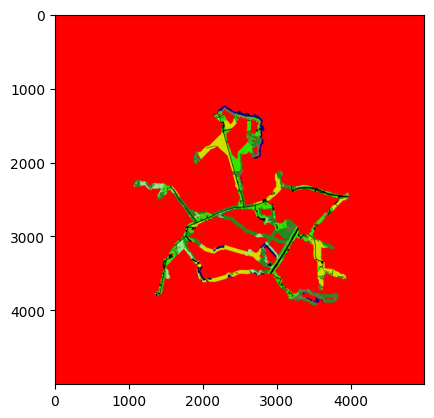

In [8]:
orig_image_df = pd.read_csv(IMAGES_DIR / "balt_standard" / 'points.csv')
orig_image_df.sort_values('img_path', inplace=True)
orig_image_df.reset_index(drop=True, inplace=True)
input_map = LandCoverComplexMap.from_map_folder(MAPS_DIR / orig_image_df.loc[0, 'map_path'])
plt.imshow(input_map.create_floormask())
orig_image_df.head()

0.0 3.1622776601683795 -2.677945044588987 3.141592653589793
(1254.0, -661.0) (1254.0, -661.0)


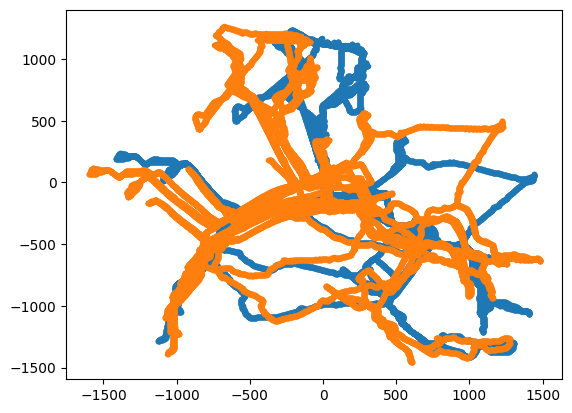

In [26]:
trajectory = [(x,y) for x,y in zip(orig_image_df['x'], orig_image_df['y'])]
trajectory_np = np.asarray([orig_image_df['x'], orig_image_df['y']]).T
deltas = np.asarray(trajectory_to_deltas(trajectory))
print(deltas[:, 0].min(), deltas[:,0].max(), deltas[:,1].min(), deltas[:,1].max())
# for 
noisy_trajectory, accumulated_heading_error = add_noise_to_trajectory(trajectory, NoiseParams(0.001, 0.001), np.random.default_rng(4))
# noisy_trajectory, accumulated_heading_error = add_noise_to_trajectory(trajectory, NoiseParams(0.0, 0.000000001), np.random.default_rng(42))
print(trajectory[0], noisy_trajectory[0])
plt.figure()
plt.scatter([x[0] for x in trajectory], [x[1] for x in trajectory], marker='.')
plt.scatter([x[0] for x in noisy_trajectory], [x[1] for x in noisy_trajectory], marker='.')

In [27]:
radial_map_config = load_json_config(CONFIGS_DIR / 'simulated_radial_configs' / 'radial_map_config.json')
swathlib = SwathLibrary.from_radial_map_config(radial_map_config, generate=True)

radial bins:   0%|                                                                                                                                                                                                                                           | 0/3 [00:00<?, ?it/s]

radial bins: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.30it/s]


In [28]:
from fitam.planning.planner_general import snap_easl_state_to_planning_state, State
from fitam.mapping.costmap import OccupancyGrid
import copy
def map_to_noisy_map(gt_map: LandCoverComplexMap, 
                     gt_trajectory: np.ndarray, 
                     noisy_trajectory: np.ndarray, 
                     accumulated_heading_offset_rad: np.ndarray, 
                     swath_lib: SwathLibrary):
    out_map = copy.deepcopy(gt_map)
    max_idx = int(np.ceil(np.abs(noisy_trajectory).max()) / gt_map.resolution) * 2 + 10 + 2 * int(swathlib.observation_radius / gt_map.resolution)
    if max_idx % 2 == 1:
        max_idx += 1
    print(max_idx)
    if max_idx > gt_map.width_pixels or max_idx > gt_map.height_pixels:
        out_map.expand((max_idx,max_idx))
        print("expanded to ", max_idx)
    # out_map.expand((8000, 8000))
    out_map_occ_grid = OccupancyGrid.from_complexmap(out_map)
    gt_occ_grid = OccupancyGrid.from_complexmap(gt_map)
    gt_flattened_layers, class_index_map = gt_map.create_flattened_class_map() 
    noisy_flattend_layers, _ = out_map.create_flattened_class_map()
    unknown_class_idx = class_index_map["unknown"]
    noisy_flattend_layers = np.ones_like(noisy_flattend_layers) * unknown_class_idx
    one_side_mask_size = int(np.ceil(swath_lib.observation_radius / swath_lib.mask_resolution)) * 2 + 1
    mask_size = (one_side_mask_size, one_side_mask_size)
    center_idx = (one_side_mask_size//2, one_side_mask_size//2)

    for true_state, noisy_state, acc_heading_error in zip(gt_trajectory, noisy_trajectory, accumulated_heading_offset_rad):
        # print(true_state, noisy_state, acc_heading_error)
        local_indices = swath_lib.get_observation_indices(center_idx, mask_size)
        gt_center_idx = gt_occ_grid.get_index_from_point(true_state)
        noisy_center_idx = out_map_occ_grid.get_index_from_point(noisy_state)
        gt_idxs = swath_lib.get_observation_indices(gt_center_idx, gt_occ_grid.data.shape)
        noisy_idxs = swath_lib.get_observation_indices(noisy_center_idx, noisy_flattend_layers.shape)
        local_observation = np.ones(mask_size, dtype=int) * unknown_class_idx
        local_observation[local_indices[0], local_indices[1]] = gt_flattened_layers[gt_idxs[0], gt_idxs[1]]
        rot_to_noisy = rotate(local_observation, np.rad2deg(acc_heading_error), reshape=False, order=0, cval=unknown_class_idx)
        # filter out unknown and invalid cells
        good_pixel_mask = rot_to_noisy[local_indices[0], local_indices[1]] != unknown_class_idx
        local_indices = (local_indices[0][good_pixel_mask], local_indices[1][good_pixel_mask])
        # print(good_pixel_mask.shape, local_indices[0].shape, noisy_idxs[0].shape)
        noisy_idxs = (noisy_idxs[0][good_pixel_mask], noisy_idxs[1][good_pixel_mask])
        noisy_flattend_layers[noisy_idxs[0], noisy_idxs[1]] = rot_to_noisy[local_indices[0], local_indices[1]]

    out_map = copy.deepcopy(gt_map)
    out_map.update_from_flattened_class_map(noisy_flattend_layers, class_index_map)
    return out_map

In [29]:
length = len(trajectory_np)
out_map = map_to_noisy_map(input_map, trajectory_np[:length], np.asarray(noisy_trajectory)[:length], accumulated_heading_error[:length], swathlib)
tmp = copy.deepcopy(input_map)
tmp.reduce_to_trajectory_visiblity([State(x,y) for x,y in trajectory_np[:length]], swathlib)

3258


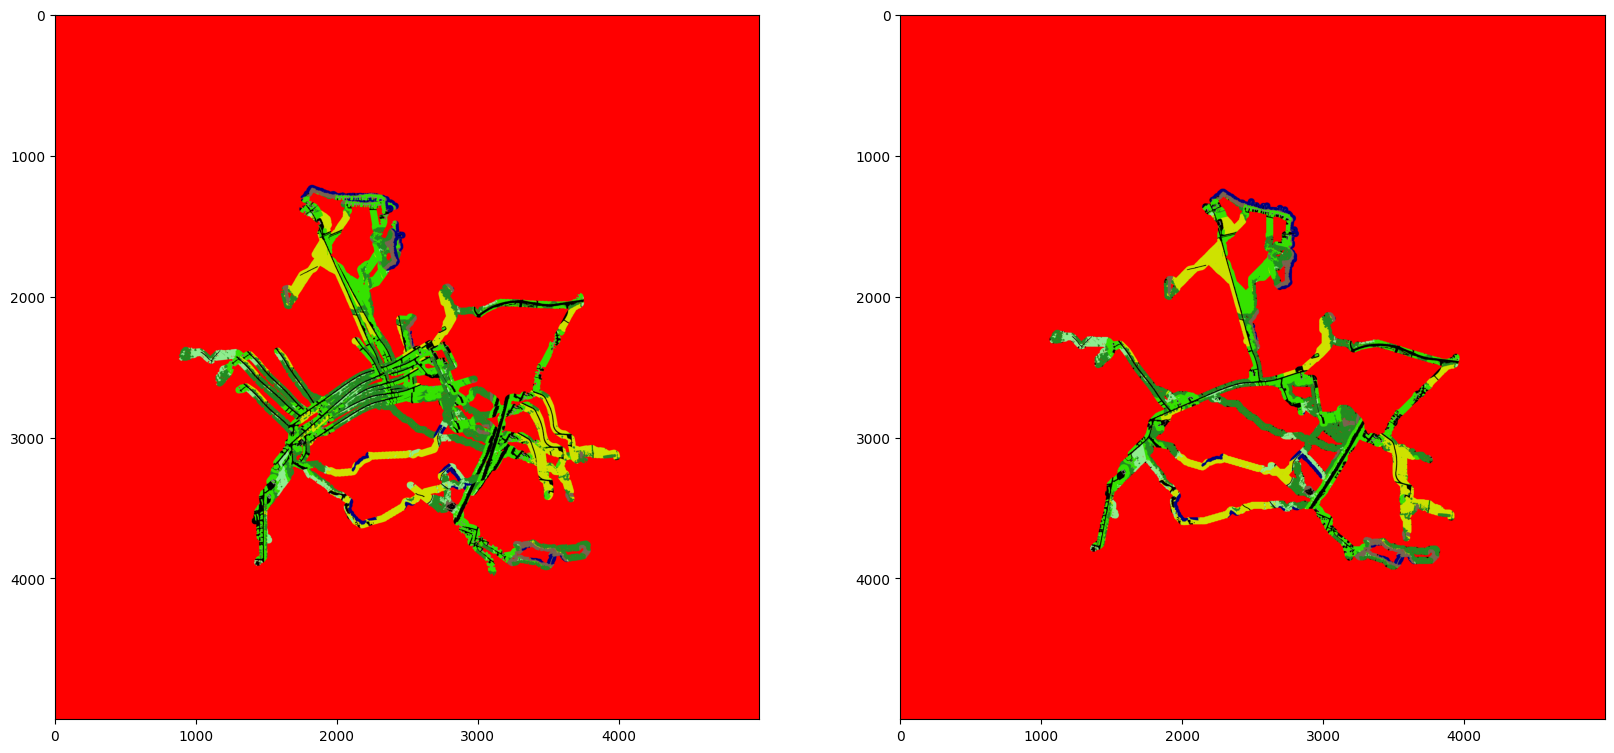

In [30]:
img = out_map.create_floormask()
gt_img = tmp.create_floormask()
# plt.imshow(img)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
bounds = [slice(0, 8000), slice(0, 8000)]
bounds2 = [slice(0, 5000), slice(0, 5000)]
ax[0].imshow(img[bounds[0], bounds[1]])
ax[1].imshow(gt_img[bounds2[0], bounds2[1]])

In [31]:
from fitam.core.common import wrap_angle_2pi
new_output_df = orig_image_df.copy()
noisy_trajectory_np = np.asarray(noisy_trajectory)
# save the new map
map_save_path = MAPS_DIR / "noisy_odom_ablation" / "map_0"
map_save_path.parent.mkdir(exist_ok=True, parents=True)
out_map.save_map(map_save_path.name, map_save_path.parent, overwrite=True)
# set map path
new_output_df["map_path"] = [str(map_save_path.relative_to(MAPS_DIR))] * len(new_output_df)
new_output_df["x"] = noisy_trajectory_np[:, 0]
new_output_df["y"] = noisy_trajectory_np[:, 1]
new_output_df["yaw_left"] = wrap_angle_2pi(np.insert(accumulated_heading_error, 0, 0))
new_output_df["yaw_right"] = wrap_angle_2pi(np.insert(accumulated_heading_error, 0, 0))


In [32]:
new_output_df.head()

,map_path,img_path,yaw_left,yaw_right,x,y,camera_name
0,noisy_odom_ablation/map_0,images/0000000_pano.png,0.000000,0.000000,1254.000000,-661.000000,main
1,noisy_odom_ablation/map_0,images/0000001_pano.png,6.282691,6.282691,1252.002292,-659.000316,main
2,noisy_odom_ablation/map_0,images/0000002_pano.png,0.001370,0.001370,1249.996221,-656.999735,main
3,noisy_odom_ablation/map_0,images/0000003_pano.png,0.001355,0.001355,1247.996799,-655.005727,main
4,noisy_odom_ablation/map_0,images/0000004_pano.png,0.001776,0.001776,1245.994500,-653.010526,main


In [35]:
from pathlib import Path
def make_noisy_image_request(base_image_request_points_csv_path: Path,
                             radial_map_config_path: Path,
                             noise_params: NoiseParams,
                             generator: np.random.Generator, 
                             map_save_dir: Path,
                             name: str,
                             ):
    orig_image_df = pd.read_csv(base_image_request_points_csv_path)
    orig_image_df.sort_values('img_path', inplace=True)
    orig_image_df.reset_index(drop=True, inplace=True)
    assert len(orig_image_df['map_path'].unique()) == 1
    input_map = LandCoverComplexMap.from_map_folder(MAPS_DIR / orig_image_df.loc[0, 'map_path'])

    radial_map_config = load_json_config(radial_map_config_path)
    swathlib = SwathLibrary.from_radial_map_config(radial_map_config, generate=True)

    trajectory = [(x,y) for x,y in zip(orig_image_df['x'], orig_image_df['y'])]
    trajectory_np = np.asarray([orig_image_df['x'], orig_image_df['y']]).T
    noisy_trajectory, accumulated_heading_error = add_noise_to_trajectory(trajectory, noise_params, generator)
    noisy_trajectory_np = np.asarray(noisy_trajectory)

    noisy_map = map_to_noisy_map(input_map,
                                 trajectory_np,
                                 noisy_trajectory_np,
                                 accumulated_heading_error,
                                 swathlib
                                 )
    
    new_output_df = orig_image_df.copy()
    # save the new map
    map_save_dir.mkdir(exist_ok=True, parents=True)
    noisy_map.save_map(name, map_save_dir, overwrite=True)
    # set map path
    new_output_df["map_path"] = [str((map_save_dir / name).relative_to(MAPS_DIR))] * len(new_output_df)
    new_output_df["x"] = noisy_trajectory_np[:, 0]
    new_output_df["y"] = noisy_trajectory_np[:, 1]
    new_output_df["yaw_left"] = wrap_angle_2pi(np.insert(accumulated_heading_error, 0, 0))
    new_output_df["yaw_right"] = wrap_angle_2pi(np.insert(accumulated_heading_error, 0, 0))
    new_output_df.to_csv(base_image_request_points_csv_path.parent / f"{name}.csv", index=False)
        

In [ ]:
# Export Datasets

noise_levels = (
    (0.0001, 0.0001),
    (0.001, 0.001),
    (0.005, 0.005),
    (0.01, 0.01),
    (0.1, 0.1),
)

base_image_request_path = IMAGES_DIR / "balt_standard" / "points.csv"
radial_map_config_path = CONFIGS_DIR / "simulated_radial_configs" / 'radial_map_config.json'
map_save_dir = MAPS_DIR / 'noisy_odom_ablation'
for i, noise_level in enumerate(noise_levels):
    name = f"noise_level_{str(noise_level[0]).replace('.', '_')}"
    generator = np.random.default_rng(i)
    make_noisy_image_request(base_image_request_path, radial_map_config_path, NoiseParams(*noise_level), generator, map_save_dir, name)


radial bins: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.36it/s]


2946


radial bins: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.32it/s]


3600


radial bins: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.32it/s]


4126


radial bins: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.33it/s]


7752
expanded to  7752


radial bins: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.34it/s]


7450
expanded to  7450


: 